In [78]:
from functions import Plasma, Spectral
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw

W = lambda z,k: np.real(lambertw(z,k=k)) # I only need the real parts

In [79]:
def velocity_profile(M, Mm, x, constant_velocity=False,acclerting=True):
    if constant_velocity:
        v = Mm*np.ones_like(x) # constant v=0.1
        return v

    if Mm < 1:
        v = M(x, Mm=Mm, k=0) # subsonic velocity profile, M_m = 0.1
    elif Mm == 1:
        if method == "FD":
            if acclerting:
                v = np.concatenate([M(x[x<0], Mm=1, k=0), [1], M(x[x>0], Mm=1, k=-1)]) # accelerating velocity profile
            else:
                v = np.concatenate([M(x[x<0], Mm=1, k=-1), [1], M(x[x>0], Mm=1, k=0)]) # decelerating velocity profile
        elif method == "CH":
            if acclerting:
                v = np.concatenate([M(x[x>0], Mm=1, k=-1), M(x[x<0], Mm=1, k=0)]) # accelerating velocity profile
            else:
                v = np.concatenate([M(x[x>0], Mm=1, k=0), M(x[x<0], Mm=1, k=-1)]) # decelerating velocity profile
    else:
        v = M(x, Mm=Mm, k=-1) # supersonic velocity profile
    return v

In [80]:
# domain information
N = 601 # number of points
domain = "symmetric"
method = "FD"
spectral = Spectral(N,domain,method)

# magnetic field, B, and velocity profile, M
B0 = 1
R = 1.5
Bm = 1+R
Delta = 0.1/0.3
B = lambda z: B0*(1+R*np.exp(-(z/Delta)**2))

# k=-1: supersonic branch
# k=0: subsonic branch
M = lambda z, Mm, k: np.sqrt( -W(-Mm**2 * (B(z)/Bm)**2 * np.exp(-Mm**2), k=k) )

E0 = 1 # unit: V/m
B0 = 1 # unit: G
Ln = -0.3 # density gradient
LE = 0.004 # shear scale
Lb = 0 # magnetic field gradient
n = 1e16 # density m^{-3}
Te = 10 # electron temperature in eV
Ti = 0 # ion temperature in eV
fluid = 'Ar' # fluid type
plasma = Plasma(n,Te,Ti,Ln,Lb,E0,B0,fluid)

x = spectral.x
Mm = 1.5
acclerting = False
constant_velocity = False
plasma.v = velocity_profile(M,Mm,x,constant_velocity,acclerting)

In [82]:
# split the polynomial eigenvalue problem into matrix
eta = 1e-1
D1 = spectral.D1
D2 = spectral.D2
I = np.eye(*D1.shape)
v0 = plasma.v 
A11 = np.zeros_like(D1)
A12 = I
A21 = np.diag(1-v0**2)@D2 \
        - np.diag((3*v0 + 1/v0)*(D1@v0))@D1 \
        - np.diag((1-1/v0**2)*(D1@v0)**2) \
        - np.diag((v0+1/v0)*(D2@v0))
A22 = 2*(np.diag(v0)@D1 + np.diag(D1@v0)) #- eta*np.diag(v0)@D2

n = 1
# A21[:n,:] = 0
# A21[-n:,:] = 0
# A22[:n,:] = 0
# A22[-n:,:] = 0
# for i in range(n):
#         A21[i,i] = 1
#         A21[-i-1,-i-1] = 1
#         A22[i,i] = 1
#         A22[-i-1,-i-1] = 1
# A = np.block([[A11, A12],[A21, A22]])

A = np.block([[A11[n:-n,n:-n], A12[n:-n,n:-n]],[A21[n:-n,n:-n], A22[n:-n,n:-n]]])
e,V = np.linalg.eig(A)

omega = -1j*e
#V = V[:x.size,:]
V = V[n:x.size-n,:]
V = np.pad(V, ((n,n),(0,0)), 'constant', constant_values=0)

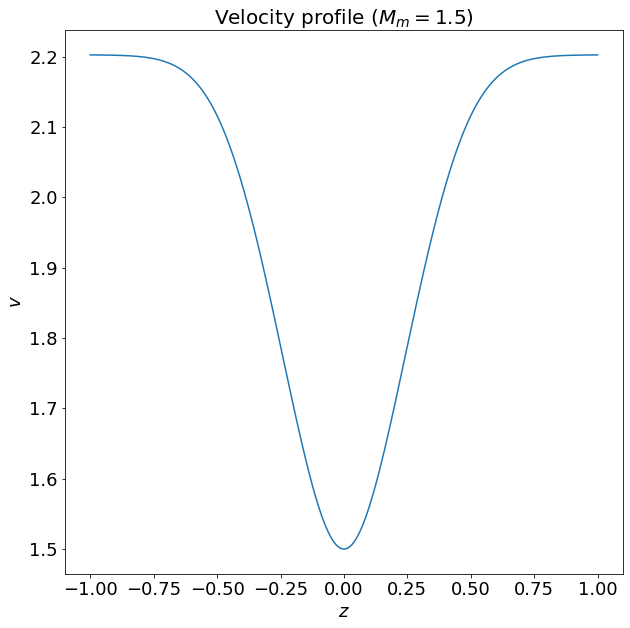

In [75]:
# velocity profile

plt.figure()
plt.plot(x, v0)
plt.title(f"Velocity profile ($M_m={Mm}$)")
plt.xlabel("$z$")
plt.ylabel("$v$");

In [65]:
# filter out ground modes
from scipy.interpolate import interp1d
xx = np.linspace(-1,1,5*N)
f = interp1d(spectral.x, V.T)
zeros = np.isclose(f(xx).T, 0, atol=1e-5).sum(axis=0)
omega = omega[zeros<int(spectral.N/10)]
V = V[:,zeros<int(spectral.N/10)]

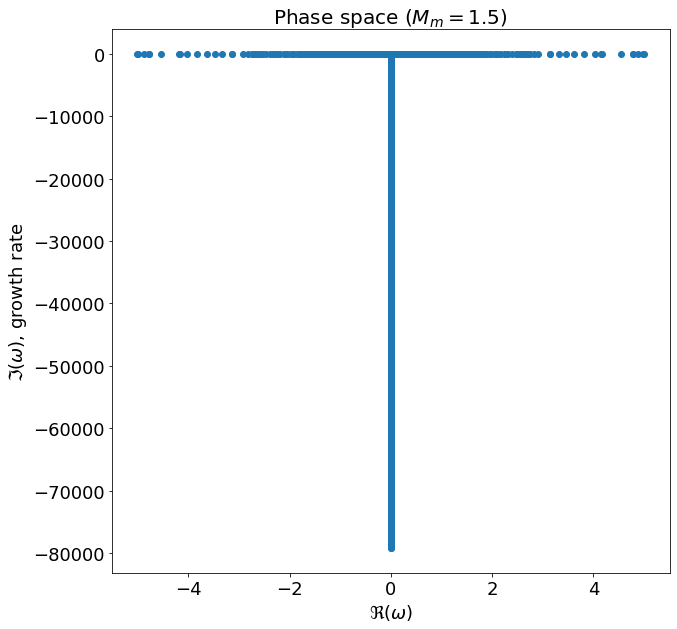

In [76]:
# phase space
plt.figure()
selection = (np.abs(np.real(omega))<100) & (np.abs(np.imag(omega))<1000)
omega_ = omega#[selection]

plt.plot(np.real(omega_), np.imag(omega_), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$, growth rate")
if (Mm == 1) & (acclerting):
    plt.title(f"Phase space ($M_m={Mm}$, accelerating)");
elif (Mm == 1) & (not acclerting):
    plt.title(f"Phase space ($M_m={Mm}$, decelerating)");
else:
    plt.title(f"Phase space ($M_m={Mm}$)");

In [77]:
# eigenvectors
plt.figure()
selection = (np.real(omega)>=0) & (np.abs(np.imag(omega))<1) 
#selection = (np.real(omega) >=0)  & (np.abs(np.imag(omega))>0.1) 
omega_ = omega[selection]
V_ = V[:, selection]

ind = np.argsort(np.abs(np.real(omega_)))
omega_ = omega_[ind]
V_ = V_[:,ind]

size = 1 if omega_.size > 5 else omega_.size
for i in range(5):
    v = V_[:,i]
    v_real = np.real(v)#/np.abs(np.real(v)).max()
    v_imag = np.imag(v)#/np.abs(np.imag(v)).max()
    lines = plt.plot(spectral.x, v_real, label=f"$\omega={omega_[i]}$")
    plt.plot(spectral.x, v_imag, '--', color=lines[0]._color)
plt.xlabel("x")
plt.ylabel("$\\tilde{v}$")
plt.title(f"Eigenvectors ($M_m={Mm}$)")
plt.legend();

IndexError: index 0 is out of bounds for axis 1 with size 0

<Figure size 720x720 with 0 Axes>

/home/practice/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


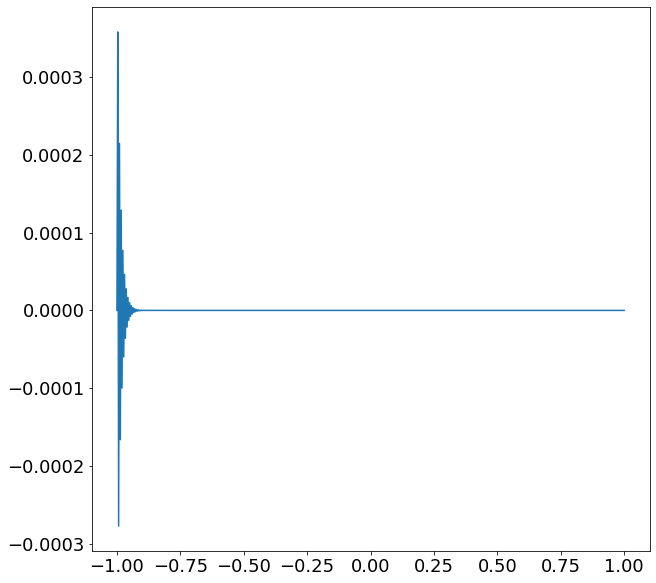

In [62]:
i = 0
w = omega_[i]
v = V_[:,i]
plt.plot(x, v)

/home/practice/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/practice/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/practice/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


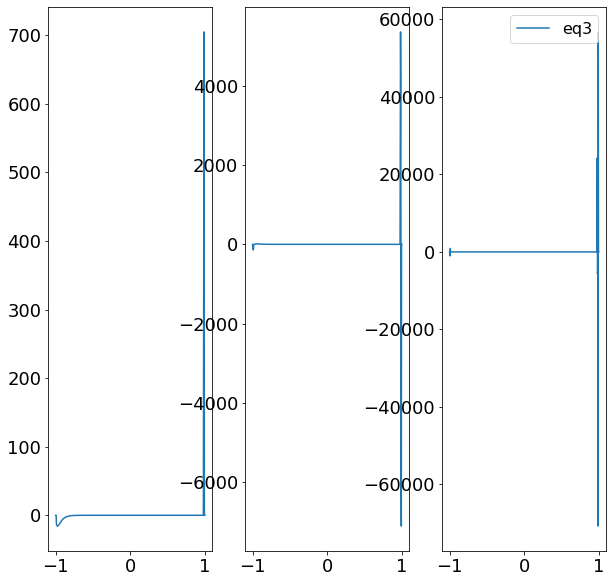

In [11]:
e = 1j*w
eq1 = -e**2*I@v 
eq2 = 2*e*np.diag(v0)@D1@v 
eq3 = np.diag(1-v0**2)@D2@v
plt.subplot(131)
plt.plot(x, eq1, label="eq1")
plt.subplot(132)
plt.plot(x, eq2, label="eq2")
plt.subplot(133)
plt.plot(x, eq3, label="eq3")
plt.legend()